# Session 2 Going Further, Discovering class-imbalance in datasets

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

Since we have done the most basic training example, got our hands on skorch and on the dataset, we are going to repeat our process using a more realistic use case. This time, our dataset will be severely unbalanced (10% of all data will be images of aircrafts), like in real life (or not even like in real life but it's getting closer).

Here, we won't guide you, you will have to use what you learned in the previous notebooks as well as what you learned in previous data science class to try to devise a way to train a good model

You are going to:
- Do a first "naive" run with the full data
- Diagnose performance
- Try to improve it by tuning several factors:
  - The dataset itself
  - The optimization parameters
  - The network architecture

**Remember that "deep learning" is still considered somewhat a black art so it's hard to know in advance what will work.**


In [30]:
# Put your imports here
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Global variables
TRAINVAL_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/large_aircraft_dataset_2023.npz"
TRAINVAL_DATASET_URL = '/tmp/large_aircraft_dataset_2023.npz'

## Q0. Downloading & splitting the dataset

You will get the following:

- 50k images in training which you should use as training & validation
- 5k images in test, which you should only use to compute your final metrics on. **Don't ever use this dataset for early stopping / intermediary metrics**

![](https://github.com/SupaeroDataScience/deep-learning/blob/main/vision/osBuF.png?raw=true)
![](https://raw.githubusercontent.com/SupaeroDataScience/deep-learning/refs/heads/main/vision/pXAfX.png)

In [3]:
# Download the dataset
ds = np.lib.npyio.DataSource("/tmp/")
f = ds.open(TRAINVAL_DATASET_URL, "rb")
trainval_dataset = np.load(f)
trainval_images = trainval_dataset["train_images"]
trainval_labels = trainval_dataset["train_labels"]
test_images = trainval_dataset["test_images"]
test_labels = trainval_dataset["test_labels"]

In [4]:
print(trainval_images.shape)
print(np.unique(trainval_labels, return_counts=True))

print(test_images.shape)
print(np.unique(test_labels, return_counts=True))

(92000, 64, 64, 3)
(array([0, 1]), array([87400,  4600]))
(20480, 64, 64, 3)
(array([0, 1]), array([19456,  1024]))


### a. Data Exploration

a. Can you plot some images ?

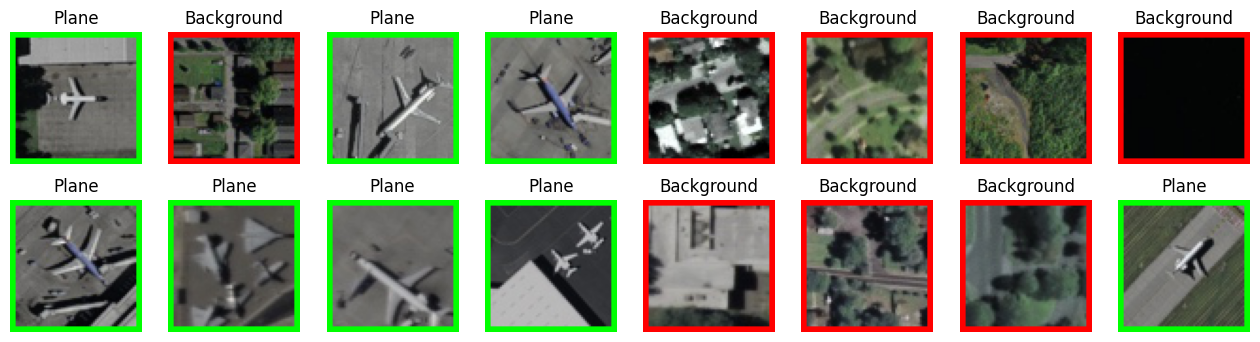

In [5]:
num_each = 8
im_size = 64
pad = 3

RED = np.array([255, 0, 0], dtype=np.uint8)
GREEN = np.array([0, 255, 0], dtype=np.uint8)

plane_idx = np.where(trainval_labels == 1)[0][:num_each]
background_idx = np.where(trainval_labels == 0)[0][:num_each]
explo_idx = np.concat([plane_idx, background_idx])
np.random.shuffle(explo_idx)

plt.figure(figsize=(16, 4))
for i, idx in enumerate(explo_idx):
    img = trainval_images[idx]
    lab = trainval_labels[idx]

    plt.subplot(2, num_each, i + 1)
    
    pimg = np.full((im_size + 2 * pad, im_size + 2 * pad, 3), RED if lab == 0 else GREEN)
    pimg[pad:-pad, pad:-pad, :] = img
    plt.imshow(pimg) 
    plt.title("Plane" if trainval_labels[idx] == 1 else "Background")
    plt.axis("off")



b. What is the aircraft/background ratio ?

In [6]:
num_planes = np.where(trainval_labels == 1)[0].size
num_background = np.where(trainval_labels == 0)[0].size
num_total = num_planes + num_background

print(f'Total number of training values: {num_total}')
print(f'Planes    : {num_planes:5d} -> {num_planes / num_total * 100:.2f}%')
print(f'Background: {num_background:5d} -> {num_background / num_total * 100:.2f}%')

Total number of training values: 92000
Planes    :  4600 -> 5.00%
Background: 87400 -> 95.00%


### b. Dataset Splitting

Here we will split the trainval_dataset to obtain a training and a validation dataset.

For example, try to use 20% of the images as validation

You must have seen that the dataset was really unbalanced, so a random sampling will not work...

Use stratified sampling to keep the label distribution between training and validation

In [7]:
# Hint to get your started
background_indexes = np.where(trainval_labels == 0)[0]
foreground_indexes = np.where(trainval_labels == 1)[0]

train_bg_indexes = background_indexes[: int(0.8 * len(background_indexes))]
valid_bg_indexes = background_indexes[int(0.8 * len(background_indexes)) :]

train_fg_indexes = foreground_indexes[: int(0.8 * len(foreground_indexes))]
valid_fg_indexes = foreground_indexes[int(0.8 * len(foreground_indexes)) :]

train_indexes = list(train_bg_indexes) + list(train_fg_indexes)
valid_indexes = list(valid_bg_indexes) + list(valid_fg_indexes)

train_images = trainval_images[train_indexes, :, :, :]
train_labels = trainval_labels[train_indexes]

valid_images = trainval_images[valid_indexes, :, :, :]
valid_labels = trainval_labels[valid_indexes]

In [8]:
from sklearn.utils import resample

# Hint to get your started
background_indexes = np.where(trainval_labels == 0)[0]
foreground_indexes = np.where(trainval_labels == 1)[0]

train_bg_indexes = background_indexes[: int(0.8 * len(background_indexes))]
valid_bg_indexes = background_indexes[int(0.8 * len(background_indexes)) :]

train_fg_indexes = foreground_indexes[: int(0.8 * len(foreground_indexes))]
valid_fg_indexes = foreground_indexes[int(0.8 * len(foreground_indexes)) :]

train_indexes = list(train_bg_indexes) + list(train_fg_indexes)
valid_indexes = list(valid_bg_indexes) + list(valid_fg_indexes)

train_images = trainval_images[train_indexes, :, :, :]
train_labels = trainval_labels[train_indexes]

valid_images = trainval_images[valid_indexes, :, :, :]
valid_labels = trainval_labels[valid_indexes]

In [9]:
print(np.unique(train_labels, return_counts=True))

(array([0, 1]), array([69920,  3680]))


In [10]:
print(np.unique(valid_labels, return_counts=True))

(array([0, 1]), array([17480,   920]))


In [11]:
# Compute the dataset statistics in [0.,1.], we're going to use it to normalize our data

mean = np.array([0.27097261, 0.28543216, 0.26042753]) # np.mean(train_images, axis=(0, 1, 2)) / 255.0
std = np.array([0.16172096, 0.15993669, 0.15175542]) # np.std(train_images, axis=(0, 1, 2)) / 255.0

mean, std

(array([0.27097261, 0.28543216, 0.26042753]),
 array([0.16172096, 0.15993669, 0.15175542]))

## Q1. Training & metrics

During Session 1, you learnt how to set up your environment on Colab, train a basic CNN on a small training set and plot metrics. Now let's do it again !

### First run

Once you have downloaded & created your training & validation dataset, use the notebook from Session 1 to get:

a. Training of the model using steps seen during Session 1

b. Compute and plot metrics (confusion matrix, ROC curve) based on this training

c. Compare the metrics between this new dataset and the one from Session 1

d. What did you expect ? Is your model working well ?

In [12]:
from typing import Callable

import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [13]:
# Apple Silicon Support
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
# NVIDIA GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
# Fallback to CPU
else:
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda:0


In [14]:
# Helper functions to get you started
class NpArrayDataset(Dataset):
    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        image_transforms: Callable = None,
        label_transforms: Callable = None,
    ):
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index: int):
        x = self.images[index]
        y = self.labels[index]

        if self.image_transforms is not None:
            x = self.image_transforms(x)
        else:
            x = torch.tensor(x)

        if self.label_transforms is not None:
            y = self.label_transforms(y)
        else:
            y = torch.tensor(y)

        return x, y

In [43]:
# Data loading
image_transforms = transforms.Compose(
    [
        # Add data augmentation ?
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

target_transforms = transforms.Lambda(lambda y: torch.tensor(y, dtype=torch.float32))

# load the training data
train_set = NpArrayDataset(
    images=train_images,
    labels=train_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# load the validation data
validation_set = NpArrayDataset(
    images=valid_images,
    labels=valid_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=True)

# load the test data
test_set = NpArrayDataset(
    images=test_images,
    labels=test_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

define your model, fill the blanks

Be careful, this time we are zero padding images so convolutions do not reduce image size !

![padding](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

In [16]:
def _init_weights(model):
    for m in model.modules():
        # Initialize all convs
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")


def model_fn():
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.model = nn.Sequential(
                # size: 3 x 64 x 64
                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
                # size: 32 x 64 x 64
                nn.ReLU(),
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                # size: 32 x 32 x 32
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                # size: 64 x 32 x 32
                nn.MaxPool2d(2),
                # size: 64 x 16 x 16
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                # size: 128 x 8 x 8
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                # size: 128 x 4 x 4
                nn.Flatten(),
                nn.Linear(in_features=128 * 4 * 4, out_features=256),
                nn.ReLU(),
                nn.Dropout(p=0.10),
                nn.Linear(in_features=256, out_features=1),
                nn.Sigmoid(),
            )

            _init_weights(self.model)

        def forward(self, x):
            y = self.model(x)
            return y.squeeze()

    return Model()


model_name = 'v1'
model = model_fn()

model.to(DEVICE)

Model(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=

In [17]:
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       9,248
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       18,496
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       36,928
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      73,856
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      147,584
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      147,584
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      147,584
│    └─ReLU: 2-19                       

In [42]:
# Load the model
model = model_fn()
model.load_state_dict(torch.load("checkpoints_google/best_v1_model_6_loss=-0.0136.pt", map_location="cpu", weights_only=True))
#model = torch.jit.script(model)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       9,248
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       18,496
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       36,928
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      73,856
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      147,584
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Conv2d: 2-16                      147,584
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      147,584
│    └─ReLU: 2-19                       

### Test metrics, introduction to PR Curves

During the previous notebook you plotted the Receiver Operating Characteristic curve. This is not ideal when dealing with imbalanced dataset since the issue of class imbalance can result in a serious bias towards the majority class, reducing the classification performance and increasing the number of **false positives**. Furthermore, in ROC curve calculation, true negatives don't have such meaning any longer.

Instead this time we will plot the Precision Recall curve of our model which uses precision and recall to evaluate models.

![](https://cdn-images-1.medium.com/fit/t/1600/480/1*Ub0nZTXYT8MxLzrz0P7jPA.png)

![](https://modtools.files.wordpress.com/2020/01/roc_pr-1.png?w=946)

Refer here for a tutorial on how to plot such curve:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

More details on PR Curve:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

**e. Plot the ROC curve of your model as well as its PR Curve, on the test set, compare them, which is easier to interpret ?**

In [ ]:
import tqdm

y_true = []
y_pred = []

# Send model to correct device
model.to(DEVICE)

# Put model in evaluatio mode (very important)
model.eval()

# Disable all gradients things
with torch.no_grad():
    for x, y_t in tqdm.tqdm(test_set, "predicting"):
        x = x.reshape((-1,) + x.shape)
        x = x.to(DEVICE)
        y = model.forward(x)
        y = y.to("cpu").numpy()

        y_t = int(y_t.to("cpu").numpy())

        y_pred.append(y)
        y_true.append(y_t)
y_pred = np.asarray(y_pred)
y_true = np.asarray(y_true)

<Figure size 640x480 with 0 Axes>

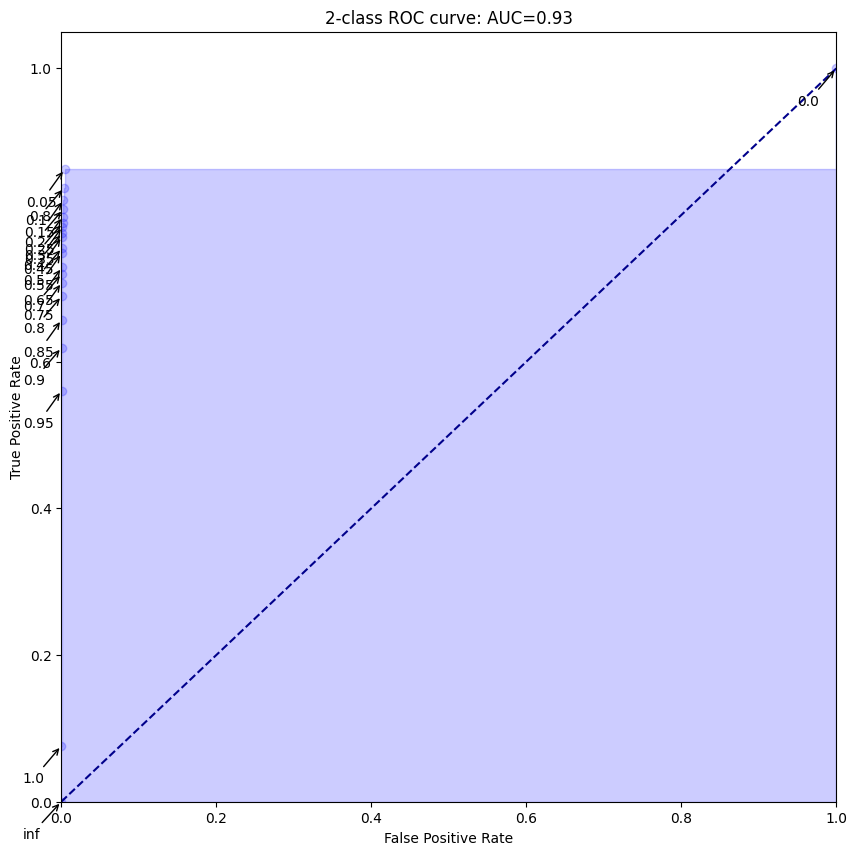

In [58]:
# Compute ROC curve and Area Under Curver

from sklearn.metrics import auc, roc_curve

# We round predictions for better readability
y_pred_probas = np.round(y_pred, 2)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probas)
roc_auc = auc(fpr, tpr)

# We round predictions every 0.05 for readability
y_pred_probas = (y_pred / 0.05).astype(np.int64) * 0.05

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probas)
roc_auc = auc(fpr, tpr)

plt.clf()
fig = plt.figure(figsize=(10, 10))
plt.step(fpr, tpr, "bo", alpha=0.2, where="post")
plt.fill_between(fpr, tpr, alpha=0.2, color="b", step="post")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("2-class ROC curve: AUC={:0.2f}".format(roc_auc))
plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")

for tp, fp, t in zip(tpr, fpr, thresholds):
    plt.annotate(
        np.round(t, 2),
        xy=(fp, tp),
        xytext=(fp - 0.05, tp - 0.05),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
    )
plt.savefig("roc_curve_thresholds.png")
plt.show()

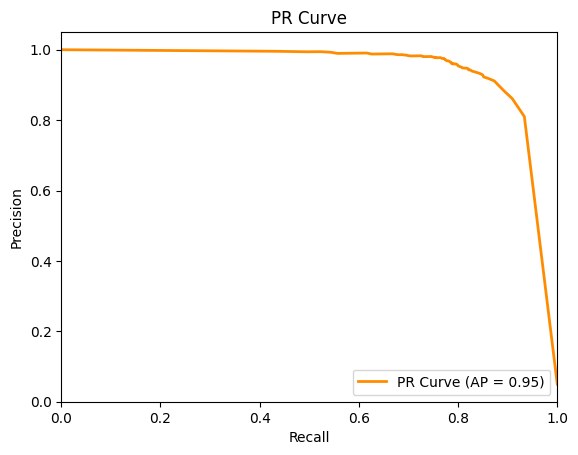

In [59]:
# Plot PR curve

# Compute PR Curve

import numpy as np
from sklearn.metrics import (
    PrecisionRecallDisplay,
    average_precision_score,
    precision_recall_curve,
)

# We round predictions for better readability
y_pred_probas = np.round(y_pred, 2)

precisions, recalls, thresholds = precision_recall_curve(
    y_true, y_pred_probas, pos_label=1
)

ap = average_precision_score(y_true, y_pred)

plt.figure()
lw = 2
plt.plot(
    recalls, precisions, color="darkorange", lw=lw, label="PR Curve (AP = %0.2f)" % ap
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend(loc="lower right")
plt.show()

**f. Can you understand why PR curve may be more useful than ROC curve for diagnosing model performance when dealing with imbalanced data ?**

In [ ]:
# Answer

**g. What is Fbeta-Score ? How can it help ? How do you chose beta?**

Some reading: https://towardsdatascience.com/on-roc-and-precision-recall-curves-c23e9b63820c

In [60]:
def fbeta(precision, recall, beta=1.0):
    if precision == 0.0 or recall == 0.0:
        return 0.0
    else:
        return (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

**h. Can you use the PR curve to choose a threshold ?**

The same way you did for the ROC curve

<Figure size 640x480 with 0 Axes>

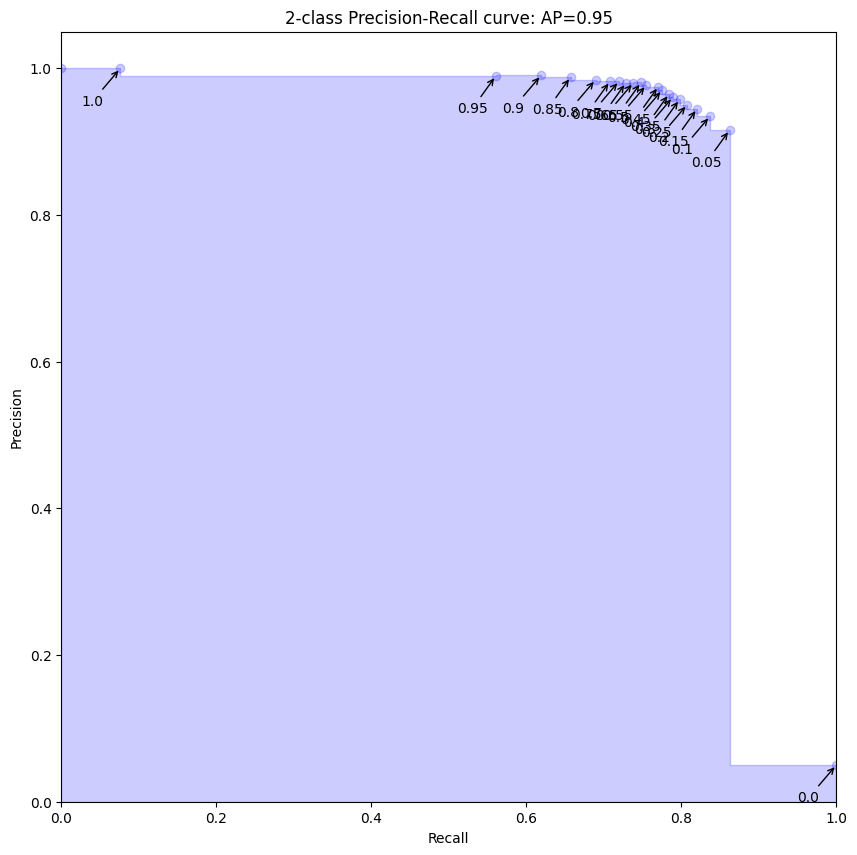

In [63]:
# We round predictions every 0.05 for readability
y_pred_probas = (y_pred / 0.05).astype(int) * 0.05

precisions, recalls, thresholds = precision_recall_curve(
    y_true, y_pred_probas, pos_label=1
)

ap = average_precision_score(y_true, y_pred)

plt.clf()
fig = plt.figure(figsize=(10, 10))
plt.step(recalls, precisions, "bo", alpha=0.2, where="post")
plt.fill_between(recalls, precisions, alpha=0.2, color="b", step="post")

for r, p, t in zip(recalls, precisions, thresholds):
    plt.annotate(
        np.round(t, 2),
        xy=(r, p),
        xytext=(r - 0.05, p - 0.05),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("2-class Precision-Recall curve: AP={:0.2f}".format(ap))
plt.show()

You can also use the fbeta score to find the best threshold, for example to maximise f1 or f2...

```python
def find_best_threshold(precisions, recalls, thresholds, beta=2.):
    best_fb = -np.inf
    best_t = None
    for t, p, r in zip(thresholds, precisions, recalls):
        fb = fbeta(p, r, beta=beta)
        if fb > best_fb:
            best_t = t
            best_fb = fb

    return best_fb, best_t
```

In [66]:
def find_best_threshold(precisions, recalls, thresholds, beta=2.):
    best_fb = -np.inf
    best_t = None
    for t, p, r in zip(thresholds, precisions, recalls):
        fb = fbeta(p, r, beta=beta)
        if fb > best_fb:
            best_t = t
            best_fb = fb

    return best_fb, best_t

print(find_best_threshold(precisions, recalls, thresholds, beta=0.5))
print(find_best_threshold(precisions, recalls, thresholds, beta=1.0))
print(find_best_threshold(precisions, recalls, thresholds, beta=2.0))

(np.float64(0.926056338028169), np.float64(0.45))
(np.float64(0.8883299798792758), np.float64(0.05))
(np.float64(0.8725296442687748), np.float64(0.05))


# Sliding window

In [67]:
# Download data
ds = np.lib.npyio.DataSource("/tmp/")
f = ds.open('/tmp/tiles_aircraft_dataset_2023.npz', "rb")
eval_tiles = np.load(f)
eval_tiles = eval_tiles["eval_tiles"]

In [90]:
import cv2

THRESHOLD = 0.05 

def apply_model_on_large_image(
    img: np.ndarray, model: nn.Module, patch_size=64, patch_stride=32
):
    h, w, c = img.shape
    coords = []

    for i0 in range(0, h - patch_size + 1, patch_stride):
        for j0 in range(0, w - patch_size + 1, patch_stride):
            patch = img[i0 : i0 + patch_size, j0 : j0 + patch_size]
            patch = image_transforms(patch).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                y_pred = model(patch)
                y_pred = y_pred.item()
                if y_pred > THRESHOLD:
                    coords.append((i0 + 32, j0 + 32))
    return coords

def plot_results_on_image(image: np.ndarray, results):
    color = (0, 255, 0)

    image0 = np.copy(image)

    for ic, jc in results:
        image = cv2.rectangle(
            image, (jc - 32, ic - 32), (jc + 32, ic + 32), color, thickness=2
        )
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    ax[0].imshow(image0)
    ax[1].imshow(image)
    plt.show()

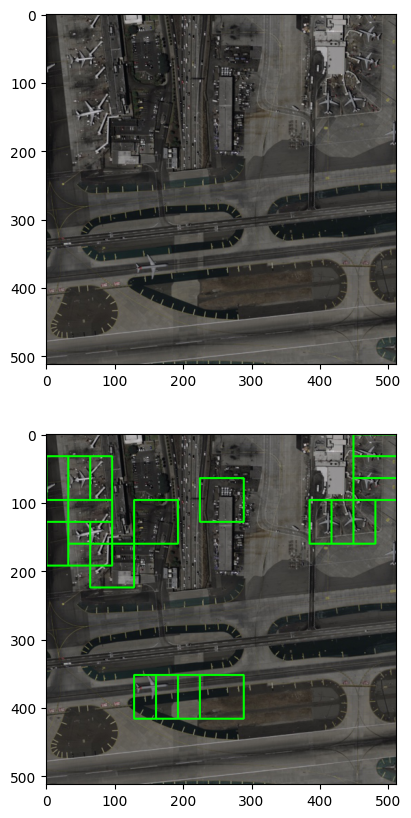

In [98]:
k = np.random.randint(eval_tiles.shape[0])
image = np.copy(eval_tiles[k])
results = apply_model_on_large_image(image, model)
plot_results_on_image(image, results)


### Plot "hard" examples

- Plot some of the missclassified examples that have true label = 0: Those are false positives
- Plot some of the missclassified examples that have true label = 1: those are false negatives (misses)

Can you interpret the false positives ?

Example for False Positives 

```python
misclassified_idxs = np.where(y_pred_classes == 1 && y_true == 0)[0]


print(len(misclassified_idxs))

print(misclassified_idxs)

misclassified_images = test_images[misclassified_idxs]
misclassified_true_labels = test_labels[misclassified_idxs]
misclassified_pred_labels = y_pred_classes[misclassified_idxs]

grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        img = np.copy(misclassified_images[i * grid_size + j])
        pred = np.copy(misclassified_pred_labels[i * grid_size + j])
        color = (0, 255, 0) if pred == 1 else (255, 0, 0)
        tile = cv2.rectangle(img, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()
```

In [ ]:
# Do it here!

## Q2. Class Imbalance

We will try several things below. Those steps are only indicative and you are free to pursue other means of improving your model.

Should you be lost, we refer you to the excellent "A Recipe for Training Neural Networks" article : https://karpathy.github.io/2019/04/25/recipe/

![image.png](docs/static/img/mlsystem.png)

### a. Tackling the imbalanced data problem

Go through your data: is the dataset balanced ? If now, which steps can I do to solve this imbalance problem ?

- Which step would you take ?
- **Don't forget to apply the same step on you train and validation dataset** but **not on your test set** as your test set should represent the final data distribution

Try to decide and a method to modify only the dataset and rerun your training. Did performance improve ?


HINT:
- It's usually a mix of **oversampling** the minority class and **undersampling** the majority class

Some readings:
- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets (very well done)
- https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/ (a bigger synthesis)
- https://machinelearningmastery.com/category/imbalanced-classification/

Hint to get you started
```python
background_indexes = np.where(trainval_labels == 0)
foreground_indexes = np.where(trainval_labels == 1)

```

**Exercise**

Rewrite your data selection to choose the same number of background and foreground classes to put into your training / validation set

Does it improve the final performance ?

### b. Hard Example Mining

Another solution is called "hard example mining" : You could balance your dataset like before, but this time do it "intelligently", for example by selecting false positives and false negatives. Those are "hard examples",

Usually we also put "easy examples" otherwise our dataset may be very biased

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTA35C_SgBtMsS1bt_VR7HC2vDaK8zIlIyw9w&usqp=CAU" alt="drawing" width="400"/>

You can see this effect easily on a confusion matrix :

<img src="https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png" alt="drawing" width="400"/>

If you want to rebalance your dataset by undersampling the 0 class, why not select more false positives than true negatives ?

**Exercise**

Rewrite your data selection to ensure there are false positives in your negative selected examples.

Does it improve the final performance ?

**Exercise**

Rewrite your data selection to ensure there are false positives in your negative selected examples.

Does it improve the final performance ?

### c. Loss function change

Sometimes, changing the loss function also helps solving the issue.

We trained with `nn.BCELoss(reduction="mean")`

Try setting [weights](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss) so that you weight more the loss on the positive samples than the negative. 

Some losses are also dedicated to very imbalanced problems, such as [the sigmoid focal loss](https://pytorch.org/vision/stable/generated/torchvision.ops.sigmoid_focal_loss.html#torchvision.ops.sigmoid_focal_loss)

**Exercise**

Try changing the loss function

## Q3. Transfer learning and Model architecture modification

There are no absolute law concerning the structure of your deep Learning model. During the [Deep Learning class](https://github.com/SupaeroDataScience/deep-learning/blob/main/deep/Deep%20Learning.ipynb) you had an overview of existing models

You can operate a modification on your structure and observe the effect on final metrics. Of course, remain consistent with credible models, cf Layer Patterns chapter on this "must view" course : http://cs231n.github.io/convolutional-networks/

See here for an introduction to complex CNNs architectures:
https://cs231n.stanford.edu/slides/2024/lecture_6_part_1.pdf

<img src="https://theaisummer.com/static/dfad9981c055b1ba1a37fb3d34ccc4d8/a1792/deep-learning-architectures-plot-2018.png" alt="archs" style="width: 400px;"/>

### Transfer Learning

For usual tasks such as classification or detection, we use "transfer learning":

    In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.
    
Adapt this tutorial to do transfer learning from a network available in torchvision to our use case

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

I advise you to select resnet18

The biggest library of pretrained models is available here :

https://github.com/rwightman/pytorch-image-models

You can also use off the shelf architecture provided by torchvision, for example:

```python
import torchvision.models

resnet18 = torchvision.models.resnet18(num_classes=2)
```

You can also use [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/) to "finetune" already trained features on your dataset

You can adapt one of those two tutorials that use either torchvision or timm to take an existing pre-trained CNN and "finetune int" for your data, while training only a few parameters

A simple option : [torchvision tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet)

A more advanced library : [timm tutorial](https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e) 

Note that `timm` is a very famous library that stores all the state of the art CNN and Vision Transformer models for your needs

**Exercise*** Change your model function for a transfer learning one. Does it improve your performance ?

## Q4. Optimizer and other hyperparameters modifications

i ) Now that you have worked on your dataset, it's time to tune your network and your training configuration

In Session 1, you tested two different optimizers. What is the effect of its modification? Apply it to your training and compare metrics.

ii ) An other important parameter is the learning rate, you can [check its effect on the behavior of your training](https://developers.google.com/machine-learning/crash-course/fitter/graph).

You can also try other things such as data augmentation, ...

Here is an overview of [possible hyperparameter tuning when training Convolutional Neural Networks](https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8)

You can try and apply those techniques to your use case.

- Does these techniques yield good results ? What about the effort-spent-for-performance ratio ?
- Do you find it easy to keep track of your experiments ?
- What would you need to have a better overview of the effects of these search ?

Don't spend too much time on this part as the next is more important. You can come back to it after you're finished

In [ ]:
# Q3.a here

## Q5. Full Test whole dataset & more improvements

a. Now that you have optimised your structure for your dataset, you will apply your model to the test dataset to see the final metrics. Plot all your metrics using the full imbalanced test set. Is it good enough ?
If you think so, you can apply it to new images using the sliding window technique with the 3rd notebook

- Did it bring any improvements ?

In [ ]:
# Q3a

b. If you're not satisfied with the output of your model, consider the following idea: Training a new model with the failures of your previous model.
Try the following:
- Get all the images with the "aircraft" label
- Get all the images with the "background" label where your best model was wrong (predicted aircraft), as well as some of the background where it was right.
- Train a new model or retrain your existing one on this dataset.


In [ ]:
# Q3b

c . **SAVE YOUR MODEL**

In [ ]:
# Q3c

**Have you saved your model ??** You will need it to relaunch the sliding window

## Food for thought

Reflect on what you just did. What is the most efficient way to gain performance ? data or model / hyperparameters ?

Reflect on what is missing from this notebook. 

Some keywords : 

- Data preparation ! aka #ETL...
- MLOps